# II - Accessing Astronomical Data From Python

Before doing to data analysis, we need to find, load and pre-process data!

## 1.- Astronomical Data from WebPages

Function to retrieve the tarball and the fits file.

In [1]:
import os
import urllib.request
import tarfile
import sys

global DOWNLOADS_DIR 
DOWNLOADS_DIR= '.'

def download_and_extract(url):
    # Obtain the filename
    name = url.rsplit('/', 1)[-1]
    filename = os.path.join(DOWNLOADS_DIR, name)
    # Download the file if not found
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
    # Decompress (if needed) and copy the selected file to the DOWNLOADS_DIR
    sdir=filename.rsplit('ReferenceImages',1)[0]+"ReferenceImages"
    if not os.path.isdir(sdir):
        tar = tarfile.open(filename)
        tar.extractall(path=DOWNLOADS_DIR)
        tar.close()

In [2]:
# Data from ALMA science verification 
twhydra_url = 'https://almascience.nrao.edu/almadata/sciver/TWHya/TWHYA_BAND7_ReferenceImages.tgz'
download_and_extract(twhydra_url)

!ls TWHYA_BAND7_ReferenceImages

TWHydra_CO3_2line.image.fits
TWHydra_CO3_2line.image.mom.weighted_coord.fits
TWHydra_CO3_2line.image.mom.weighted_dispersion_coord.fits
TWHydra_CO3_2line.image.mom0.fits
TWHydra_HCOplusline.image.fits
TWHydra_HCOplusline.image.mom.weighted_coord.fits
TWHydra_HCOplusline.image.mom.weighted_dispersion_coord.fits
TWHydra_HCOplusline.image.mom0.fits
TWHydra_contall_apcal.image.fits


## 2.- Loading and a Quick Look at the Data

In [3]:
from astropy.io import fits
import logging
import warnings
warnings.filterwarnings('ignore')

# Load File
hdulist = fits.open("TWHYA_BAND7_ReferenceImages/TWHydra_CO3_2line.image.mom0.fits")
twhydra = hdulist[0]

### Show the header

In [4]:
twhydra.header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    1                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   4.668472210566E-04                                                  
BMIN    =   4.255372948117E-04                                                  
BPA     =   2.230152130127E+01                                                  
BTYPE   = 'Intensity'       

### Quick Look
We can use matplotlib

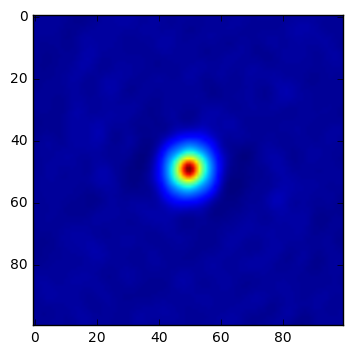

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(twhydra.data.sum(axis=(0,1)))

INFO: Setting slices=[0, 0] [aplpy.core]
INFO: Auto-setting vmin to -9.227e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.636e+00 [aplpy.core]


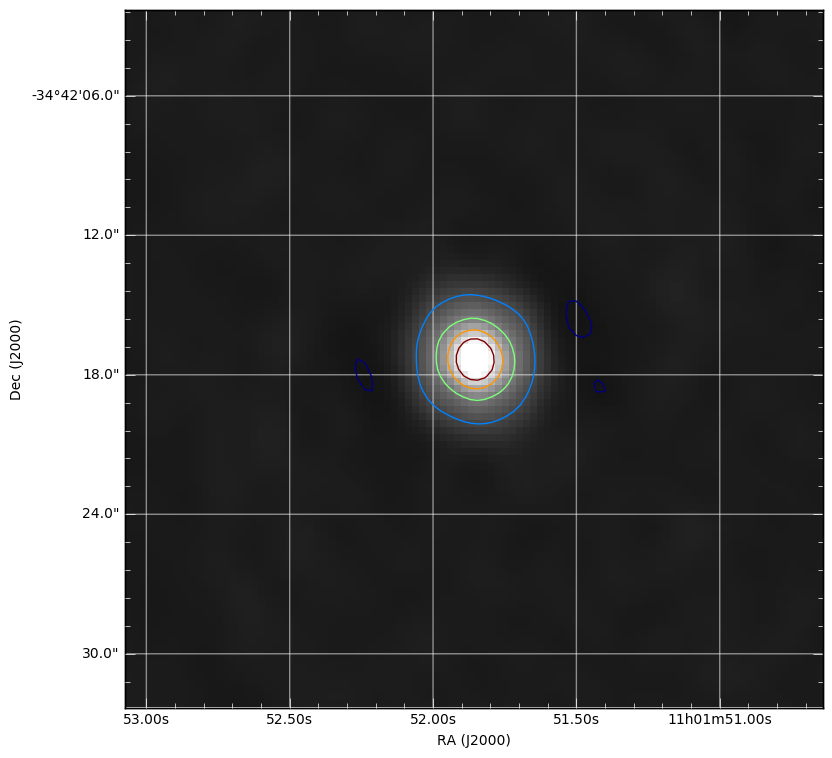

In [6]:
import aplpy 
fig = aplpy.FITSFigure(twhydra)
fig.show_grayscale()
fig.show_grid()
fig.show_contour()

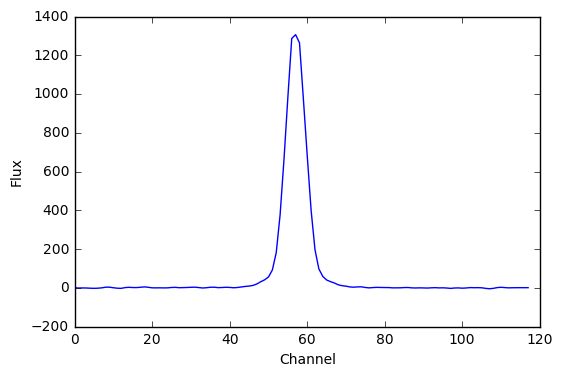

In [7]:
#Load Data Cube
hdulist = fits.open("TWHYA_BAND7_ReferenceImages/TWHydra_CO3_2line.image.fits")
twhydra_cube = hdulist[0]

def show_spectra(cube):
    spec = cube.sum(axis=(0,2,3))
    plt.plot(spec)
    plt.ylabel('Flux')
    plt.xlabel('Channel')

show_spectra(twhydra_cube.data)
plt.show()

## Interactivity

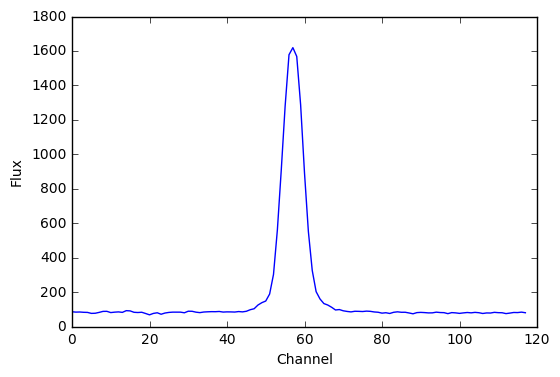

In [8]:
from ipywidgets import interact

def interactive_denoising(threshold=0.0):
    cube=twhydra_cube.data.copy()
    cube[cube<threshold] = 0
    show_spectra(cube)
    plt.show()

mmax = twhydra_cube.data.max()
mmin = twhydra_cube.data.min()
print(mmax,mmin)
res=interact(interactive_denoising,threshold=(mmin,mmax))

In [9]:
limits = res.widget.kwargs
limits

{'threshold': 0.0}

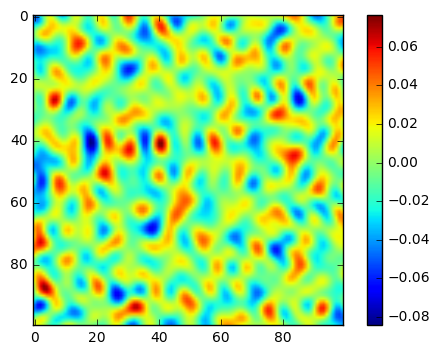

<function __main__.explore_channels>

In [10]:
cube=twhydra_cube.data[0]
def explore_channels(chan=0):
    plt.imshow(cube[chan])
    plt.colorbar()
    plt.show()

interact(explore_channels,chan=(0,cube.shape[0]-1))

## 3 Catalog Access

In [11]:
from astroquery.skyview import SkyView
SkyView.list_surveys()

{'All:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                       'GOODS: Chandra ACIS FB',
                       'GOODS: Chandra ACIS SB',
                       'GOODS: VLT VIMOS U',
                       'GOODS: VLT VIMOS R',
                       'GOODS: HST ACS B',
                       'GOODS: HST ACS V',
                       'GOODS: HST ACS I',
                       'GOODS: HST ACS Z',
                       'Hawaii HDF U',
                       'Hawaii HDF B',
                       'Hawaii HDF V0201',
                       'Hawaii HDF V0401',
                       'Hawaii HDF R',
                       'Hawaii HDF I',
                       'Hawaii HDF z',
                       'Hawaii HDF HK',
                       'GOODS: HST NICMOS',
                       'GOODS: VLT ISAAC J',
                       'GOODS: VLT ISAAC H',
                       'GOODS: VLT ISAAC Ks',
                       'HUDF: VLT ISAAC Ks',
                       'GOODS: Spitzer IRAC 3

In [32]:
res=SkyView.get_image_list(position='M100',survey=['DSS'])
print(res)

['http://skyview.gsfc.nasa.gov/tempspace/fits/skv8603475424398.fits']


INFO: Auto-setting vmin to  2.300e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.391e+04 [aplpy.core]


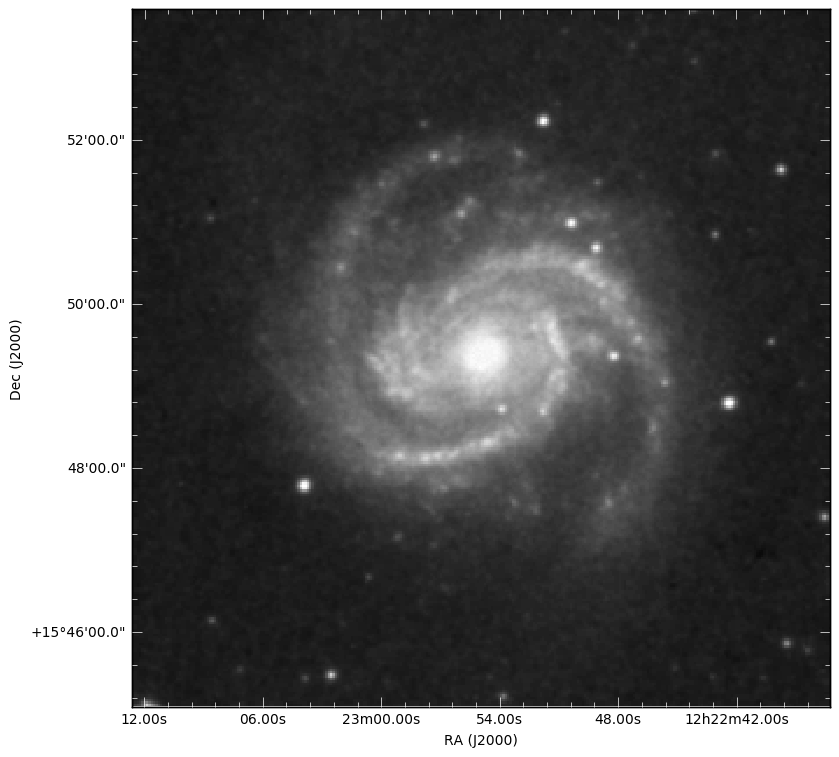

In [33]:
urllib.request.urlretrieve(res[0],'opt.fits')
hdulist = fits.open("opt.fits")
opt = hdulist[0] 
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()

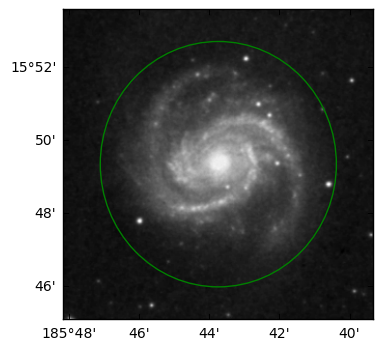

In [34]:

from astropy.wcs import WCS
from matplotlib.patches import Circle
ra=opt.header['CRVAL1']
dec=opt.header['CRVAL2']
mywcs=WCS(opt.header)
max_radius=0.09

def select_radius(radius=max_radius):
    ax=plt.subplot(111,projection=mywcs)
    ax.imshow(opt.data,cmap="gray",origin='lower')
    cc=Circle((ra,dec),radius=radius,edgecolor="green",facecolor="none",transform=ax.get_transform('fk5'))
    ax.add_patch(cc)
    
mycirc=interact(select_radius,radius=(0.0,max_radius,max_radius/1000))

In [35]:
limits = mycirc.widget.kwargs
rad    = limits['radius']
print(ra,dec)
rad

185.729 15.8224


0.05607

In [36]:
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs(keywords=['GAIA'])
for key,item in catalog_list.items():
    print(key+" : "+item.description)

J/A+A/574/L7 : Gaia-ESO Survey: Li-rich stars in NGC2547 (Sacco+, 2015)
J/MNRAS/426/1767 : Gaia spectrophotometric standard stars I. (Pancino+, 2012)
J/AJ/151/79 : Radio fluxes of 195 ICRF2-Gaia transfer sources (Le Bail+, 2016)
J/MNRAS/418/863 : NLTE corrections for Mg and Ca lines (Merle+ 2011)
J/A+A/575/A26 : Properties of the Population II star HD 140283 (Creevey+, 2015)
J/A+A/561/A94 : Velocities and photometry in Trumpler 20 (Donati+, 2014)
J/A+A/563/A94 : Kinematics of the Gamma Vel cluster (Jeffries+, 2014)
J/A+A/589/A70 : Gamma Vel cluster membership and IMF (Prisinzano+, 2016)
J/A+A/573/A115 : Radial velocities in seven globular clusters (Lardo+, 2015)
J/A+A/565/A11 : Gaia photometry for white dwarfs (Carrasco+, 2014)
J/MNRAS/462/3616 : Gaia SPSS variability monitoring (Marinoni+, 2016)
J/A+A/591/A74 : Nebular emission lines towards NGC3372 center (Damiani+, 2016)
J/A+A/366/1003 : 8500-8750{AA} high resolution spectroscopy. III. (Munari+, 2001)
J/A+A/566/A50 : Classification 

In [37]:
from astropy.coordinates import SkyCoord
import astropy.units as u

c = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
res=Vizier.query_region(c, radius=rad*u.deg, catalog='I/337')

In [38]:
restab=res[0]
restab

_RAJ2000,_DEJ2000,_r,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,SolID,Source,RandomI,Epoch,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,RADEcor,RAPlxcor,RApmRAcor,RApmDEcor,DEPlxcor,DEpmRAcor,DEpmDEcor,PlxpmRAcor,PlxpmDEcor,pmRApmDEcor,NAL,NAC,NgAL,NgAC,NbAL,NbAC,DQ,epsi,sepsi,APF,ARF,WAL,WAC,Apr,MatchObs,Dup,sK1,sK2,sK3,sK4,mK1,mK2,mK3,mK4,o__Gmag_,__FG_,e__FG_,__Gmag_,Var,GLON,GLAT,ELON,ELAT
deg,deg,deg,deg,mas,deg,mas,,,,yr,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / mas2,,,,,,,,deg,deg,deg,deg,,e-/s,e-/s,mag,,deg,deg,deg,deg
float64,float64,float64,float64,float32,float64,float32,int64,int64,int64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,float64,float32,float32,uint8,float32,float64,float32,uint8,int16,uint8,float32,float32,float32,float32,float64,float64,float64,float64,int16,float32,float32,float32,bytes13,float64,float64,float64,float64
185.7536671,15.7772661,0.050991,185.7536671431,0.649,15.7772660653,0.420,1635378410781933568,3945389771656354048,45706763,2015.0,--,--,--,--,--,--,-0.886,--,--,--,--,--,--,--,--,--,277,0,276,0,1,0,0.00,1.67,24,0,1.60,0.224,--,2,34,0,0.373,0.741,0.355,0.445,-155.61232000,24.75964400,-33.96331000,26.36036700,275,1142,6.034,17.881,NOT_AVAILABLE,271.3251388995,76.8711674682,178.8248560356,16.7285366406
185.7490072,15.7829956,0.043852,185.7490072244,4.344,15.7829955829,2.459,1635378410781933568,3945389775951183104,857244113,2015.0,--,--,--,--,--,--,-0.876,--,--,--,--,--,--,--,--,--,69,0,69,0,0,0,0.00,1.88,0.58,0,7.29,0.023,--,2,11,0,0.740,0.700,0.646,0.363,-164.64787000,29.88515000,-35.37972300,33.00041200,67,96.24,1.908,20.566,NOT_AVAILABLE,271.2956383904,76.8740038882,178.8181196189,16.7319007773
185.7663895,15.7957588,0.044761,185.7663895347,0.193,15.7957588061,0.114,1635378410781933568,3945389874735544192,750453877,2015.0,--,--,--,--,--,--,-0.900,--,--,--,--,--,--,--,--,--,262,0,262,0,0,0,0.00,0.55,1.4e+02,0,3.58,3.016,--,2,30,0,0.344,0.722,0.358,0.402,-155.93983000,22.79654300,-34.14112000,23.43173400,260,4.459e+04,21.25,13.902,NOT_AVAILABLE,271.3328315312,76.8932765822,178.8285165263,16.7504358034
185.7381228,15.8019287,0.022270,185.7381227640,4.936,15.8019286598,3.374,1635378410781933568,3945390050828621056,611818202,2015.0,--,--,--,--,--,--,-0.832,--,--,--,--,--,--,--,--,--,184,0,172,0,12,0,0.00,13.35,95,0,51.39,0.005,--,2,25,1,0.501,0.844,0.572,0.625,-148.03813000,28.73999000,-29.56824000,29.42702500,175,211,2.497,19.714,NOT_AVAILABLE,271.2147959191,76.8854669851,178.7999893000,16.7448125636
185.7461791,15.8020493,0.026213,185.7461790790,48.893,15.8020492870,15.002,1635378410781933568,3945390149615599488,812680814,2015.0,--,--,--,--,--,--,-0.939,--,--,--,--,--,--,--,--,--,50,0,47,0,3,0,0.00,16.60,2.9e+02,0,85.98,0.003,--,2,7,0,0.333,0.929,0.410,0.735,-136.19693000,23.01010300,-19.63590200,22.34117000,48,166.3,3.524,19.972,NOT_AVAILABLE,271.2443989181,76.8893402960,178.8073086279,16.7481263238
185.7477853,15.8152513,0.019431,185.7477853061,54.062,15.8152513394,26.222,1635378410781933568,3945390153907852032,49444977,2015.0,--,--,--,--,--,--,-0.974,--,--,--,--,--,--,--,--,--,75,0,71,0,4,0,0.00,16.27,63,0,62.65,0.003,--,2,12,0,0.996,0.986,0.969,0.946,-143.69843000,36.34280800,-23.58861000,36.50693500,74,190,3.344,19.828,NOT_AVAILABLE,271.2220552803,76.9016292765,178.8030796676,16.7607866849
185.7493265,15.8153907,0.020770,185.7493264663,43.634,15.8153906916,13.363,1635378410781933568,3945390153907852288,166325054,2015.0,--,--,--,--,--,--,-0.898,--,--,--,--,--,--,--,--,--,65,0,64,0,1,0,0.00,12.76,3.1e+02,0,49.15,0.005,--,2,10,1,0.955,0.939,0.846,0.765,-148.97383000,30.55778300,-28.72899600,30.96921700,58,129.7,3.444,20.242,NOT_AVAILABLE,271.2274743148,76.9024719422,178.8044296448,16.7615264805
185.7610082,15.8251025,0.030909,185.7610081654,0.842,15.8251025328,0.583,1635378410781933568,3945390183975337984,718197325,2015.0,--,--,--,--,--,--,-0

INFO: Auto-setting vmin to  2.300e+03 [aplpy.core]
INFO: Auto-setting vmax to  1.391e+04 [aplpy.core]


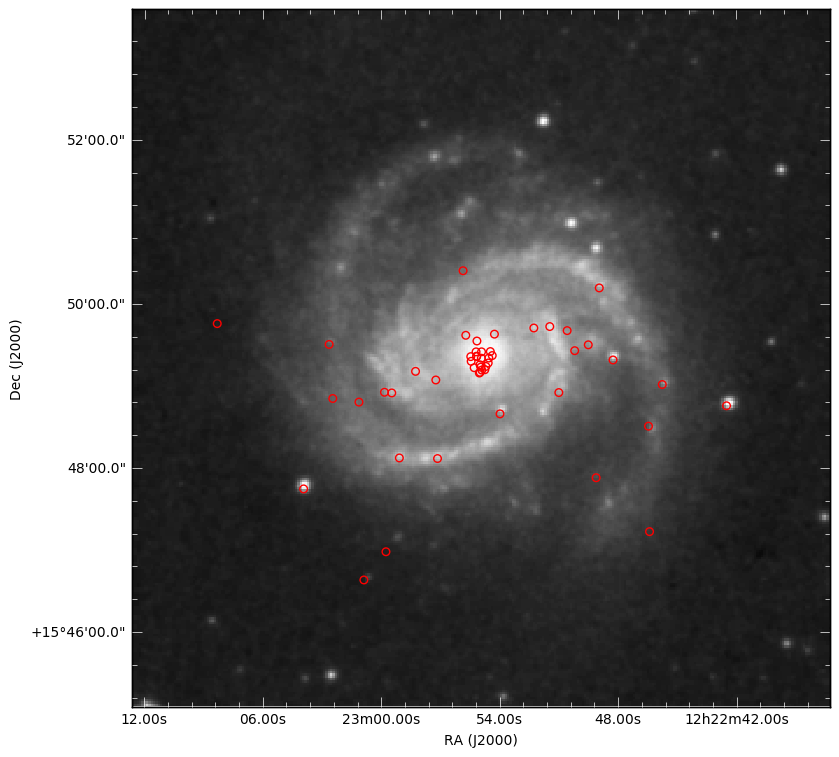

In [39]:
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()
#fig.show_markers(restab['ra'],restab['dec'])
fig.show_markers(restab['RA_ICRS'],restab['DE_ICRS'])

### With ALMA

In [42]:
res=SkyView.get_image_list(position='M100',survey=['NVSS'])
res

['http://skyview.gsfc.nasa.gov/tempspace/fits/skv8601244243024.fits']

INFO: Auto-setting vmin to -3.080e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.604e-02 [aplpy.core]


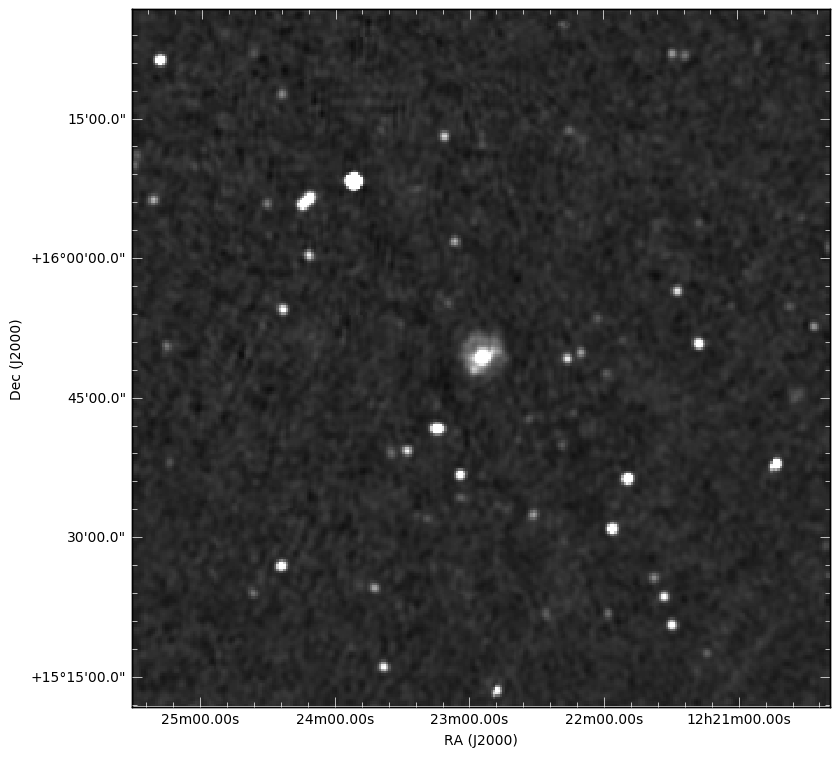

In [43]:
urllib.request.urlretrieve(res[0],'opt.fits')
hdulist = fits.open("opt.fits")
opt = hdulist[0] 
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()

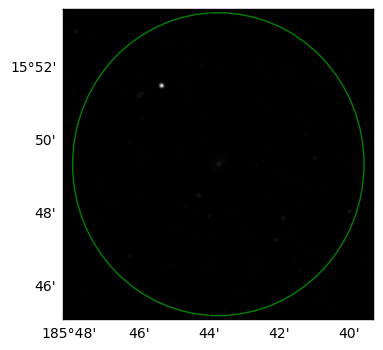

In [44]:
mycirc=interact(select_radius,radius=(0.0,max_radius,max_radius/1000))

In [45]:
limits = mycirc.widget.kwargs
rad    = limits['radius']
print(ra,dec)
rad

185.729 15.8224


0.06921

In [46]:
from astropy.vo.client import vos_catalog
catalog=vos_catalog.VOSCatalog.create("ChiVO ALMA",
                                      "http://10.6.91.206/archive_alma/q/scs-archive-alma/scs.xml?")
catalog.dumps()

'{\n    "title": "ChiVO ALMA",\n    "url": "http://10.6.91.206/archive_alma/q/scs-archive-alma/scs.xml?"\n}'

In [47]:
res=vos_catalog.call_vo_service('conesearch_good',
                            catalog_db=catalog,
                            kwargs={'RA': ra, 'DEC': dec,'SR': rad})

Trying http://10.6.91.206/archive_alma/q/scs-archive-alma/scs.xml?


VOSError: None of the available catalogs returned valid results. (1 URL(s) timed out.)

In [ ]:
almatab=res.to_table()
almatab.show_in_notebook()

In [ ]:
%matplotlib notebook
fig = aplpy.FITSFigure(opt)
fig.show_grayscale()
fig.show_markers(almatab['s_ra'],almatab['s_dec'])